<a href="https://colab.research.google.com/github/sergiopaniego/BehaviorStudio-experiments/blob/main/dataset_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/My Drive"
!ls "/content/drive/My Drive/complete_dataset.zip"
!unzip "/content/drive/My Drive/curves_only.zip"
!unzip "/content/drive/My Drive/complete_dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: complete_dataset/Images/4655.png  
  inflating: complete_dataset/Images/13432.png  
  inflating: complete_dataset/Images/13393.png  
  inflating: complete_dataset/Images/14645.png  
  inflating: complete_dataset/Images/16896.png  
  inflating: complete_dataset/Images/4638.png  
  inflating: complete_dataset/Images/12695.png  
  inflating: complete_dataset/Images/13074.png  
  inflating: complete_dataset/Images/16020.png  
  inflating: complete_dataset/Images/15454.png  
  inflating: complete_dataset/Images/690.png  
  inflating: complete_dataset/Images/8168.png  
  inflating: complete_dataset/Images/4244.png  
  inflating: complete_dataset/Images/16078.png  
  inflating: complete_dataset/Images/6062.png  
  inflating: complete_dataset/Images/7468.png  
  inflating: complete_dataset/Images/1326.png  
  inflating: complete_dataset/Images/2106.png  
  inflating: complete_dataset/Images/585.png  
  inflating: complete_dataset/

In [79]:
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split


def load_data(folder):
    name_folder = '/content/' + folder + '/Images/'
    list_images = glob.glob(name_folder + '*')
    print(list_images)
    images = sorted(list_images, key=lambda x: int(x.split('/')[4].split('.png')[0]))
    name_file = '/content/' + folder + '/data.json'
    file = open(name_file, 'r')
    data = file.read()
    file.close()
    return images, data

def get_images(list_images, type_image, array_imgs):
    # Read the images
    for name in list_images:
        img = cv2.imread(name)
        # CHANGE BGR TO RGB IF NEEDED
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if type_image == 'cropped':
            img = img[240:480, 0:640]
        img = cv2.resize(img, (int(img.shape[1] / 4), int(img.shape[0] / 4)))
        array_imgs.append(img)
    return array_imgs

def parse_json(data, array):
    # Process json
    data_parse = data.split('}')[:-1]
    for d in data_parse:
        v = d.split('"v": ')[1]
        d_parse = d.split(', "v":')[0]
        w = d_parse.split(('"w": '))[1]
        array.append((float(v), float(w)))

    return array

def preprocess_data(array_ann, array_imgs):
    # Data augmentation
    # Take the image and just flip it and negate the measurement
    print(len(array_ann))
    flip_imgs = []
    array_flip = []
    for i in range(len(array_ann)):
        flip_imgs.append(cv2.flip(array_imgs[i], 1))
        array_flip.append((array_ann[i][0], -array_ann[i][1]))
    new_array_ann = array_ann + array_flip
    new_array_imgs = array_imgs + flip_imgs
    print(len(array_ann))
    return new_array_ann, new_array_imgs

def add_extreme_data(array_ann, array_imgs):
    print(len(array_ann))
    # Adds extreme data (repeated images with intense curve)
    for i in range(0, len(array_ann)):
        if abs(array_ann[i][1]) >= 1:
            if abs(array_ann[i][1]) >= 2:
                num_iter = 10
            else:
                num_iter = 5
            for j in range(0, num_iter):
                array_ann.append(array_ann[i])
                array_imgs.append(array_imgs[i])
        if float(array_ann[i][0]) <= 2:
            # print(array_ann[i][0])
            print(i)
            array_ann.append(array_ann[i])
            array_imgs.append(array_imgs[i])
    print(len(array_ann))
    return array_ann, array_imgs


# Load data
images, data = load_data('complete_dataset')
images_curve, data_curve = load_data('curves_only')

# CHANGE type_image
type_image = 'cropped'
# type_image='normal'

# Preprocess images
array_imgs = []
array_imgs = get_images(images, type_image, array_imgs)
array_imgs = get_images(images_curve, type_image, array_imgs)
# Preprocess json
array_annotations = []
array_annotations = parse_json(data, array_annotations)
array_annotations = parse_json(data_curve, array_annotations)


if type_image == 'cropped':
    img_shape = (65, 160, 3)
else:
    img_shape = (120, 160, 3)


# Adapt the data
array_annotations, array_imgs = preprocess_data(array_annotations, array_imgs)
# x = x[:]
array_annotations, array_imgs = add_extreme_data(array_annotations, array_imgs)

'''
# START NORMALIZE DATA
array_annotations_v = []
array_annotations_w = []

for annotation in array_annotations:
  array_annotations_v.append(annotation[0])
  array_annotations_w.append(annotation[1])
  
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))
normalized_X = normalize(array_annotations_v)
normalized_Y = normalize(array_annotations_w)


normalized_annotations = []
for i in range(0, len(normalized_X)):
  normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])

normalized_annotations = np.stack(normalized_annotations, axis=0)
array_annotations = normalized_annotations
# END NORMALIZE DATA
'''

# images_train, images_validation, annotations_train, annotations_validation = train_test_split(array_imgs, array_annotations, test_size=0.20, random_state=42)
# FOR LSTMs, shuffle = FALSE!!!!!!!
images_train, images_validation, annotations_train, annotations_validation = train_test_split(array_imgs, array_annotations, test_size=0.20, random_state=42, shuffle=False)


# Adapt the data
images_train = np.stack(images_train, axis=0)
annotations_train = np.stack(annotations_train, axis=0)
images_validation = np.stack(images_validation, axis=0)
annotations_validation = np.stack(annotations_validation, axis=0)


['/content/complete_dataset/Images/16241.png', '/content/complete_dataset/Images/13309.png', '/content/complete_dataset/Images/14089.png', '/content/complete_dataset/Images/498.png', '/content/complete_dataset/Images/8366.png', '/content/complete_dataset/Images/8347.png', '/content/complete_dataset/Images/13375.png', '/content/complete_dataset/Images/14940.png', '/content/complete_dataset/Images/4543.png', '/content/complete_dataset/Images/4834.png', '/content/complete_dataset/Images/9124.png', '/content/complete_dataset/Images/5436.png', '/content/complete_dataset/Images/2300.png', '/content/complete_dataset/Images/10346.png', '/content/complete_dataset/Images/17046.png', '/content/complete_dataset/Images/3566.png', '/content/complete_dataset/Images/5496.png', '/content/complete_dataset/Images/5969.png', '/content/complete_dataset/Images/790.png', '/content/complete_dataset/Images/1542.png', '/content/complete_dataset/Images/5614.png', '/content/complete_dataset/Images/3651.png', '/co

complete:
17341
curves:
5268
complete+curves:
22609
total dataset:
45218
Strong changes:
3
0
0
15788
(-0.6, -1.0)


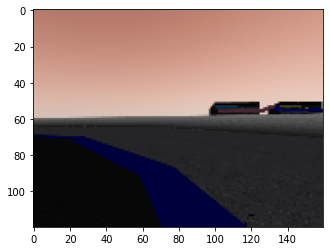

15789
(-0.6, -1.0)


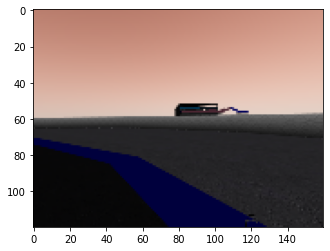

15790
(11.0, -0.0114)


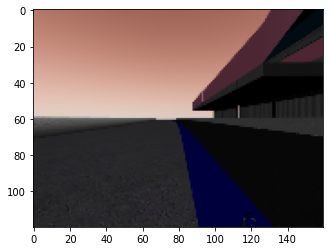

15791
(11.0, 0.0295)


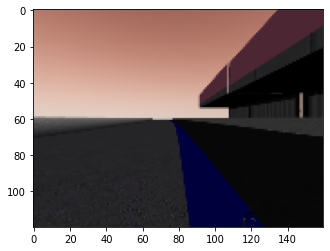

15792
(13.0, 0.09780000000000001)


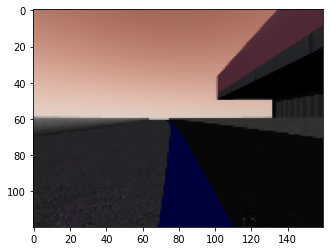

In [66]:
import os
import matplotlib.pyplot as plt

folder = "/content/complete_dataset/Images/"
print('complete:')
images_1 = len([name for name in os.listdir(folder) if True])
print(images_1)
folder = "/content/curves_only/Images/"
print('curves:')
images_2 = len([name for name in os.listdir(folder) if True])
print(images_2)

print('complete+curves:')
print(images_1+images_2)

'''
Todas las imágenes son 17406 (curves + complete)
Se suman el doble de imágenes a partir de 17406 haciendo un flip. 
Así que debería de haber cambios en:
* 17341
* 17341 + 5268
* 17341 + 5268 + 17341
* 17341 + 5268 + 17341 + 5268

Además de estos cambios, dentro de cada uno hay cambios por ser de varios circuitos. 

'''

print('total dataset:')
print(len(array_imgs))

'''
print(array_annotations[0])
plt.imshow(array_imgs[0])
plt.show()
print(array_annotations[1])
plt.imshow(array_imgs[1])
plt.show()
'''
######
'''
for i in range(17330, 17350):
  print(i)
  print(array_annotations[i])
  plt.imshow(array_imgs[i])
  plt.show()
'''

'''
# Cambio de contexto 1 entre imagenes complete_dataset y curves_only
print('-- CONTEXT CHANGE 1 --')
print('complete_dataset-curves_only')
print(array_annotations[17340])
plt.imshow(array_imgs[17340])
plt.show()
print(array_annotations[17341])
plt.imshow(array_imgs[17341])
plt.show()
print('---------------------')

# Cambio de contexto 2 entre curves_only y flip de complete_dataset
print('-- CONTEXT CHANGE 2 --')
print('curves_only-flip_complete_dataset')
print(array_annotations[22608])
plt.imshow(array_imgs[22608])
plt.show()
print(array_annotations[22609])
plt.imshow(array_imgs[22609])
plt.show()
print('---------------------')

# Cambio de contexto 3 entre flip de complete_dataset y flip de curves_only
print('-- CONTEXT CHANGE 3 --')
print('flip_complete_dataset-flip_curves_only')
print(array_annotations[39949])
plt.imshow(array_imgs[39949])
plt.show()
print(array_annotations[39950])
plt.imshow(array_imgs[39950])
plt.show()
print('---------------------')

# Cambio de contexto 4
print('-- CONTEXT CHANGE 4 --')
print('')

'''
previous_v = 0
previous_w = 0
strong_changes_v = []
strong_changes_w = []
strong_changes_v_w = []
for i in range(22609, 22620):
  #print('-----')
  #print(array_annotations[i])
  #plt.imshow(array_imgs[i])
  #plt.show()
  if abs(array_annotations[i][0] - previous_v) > 7:
    #print('-----')
    #print(array_annotations[i][0])
    #print(previous_v)
    #print(abs(array_annotations[i][0] - previous_v))
    #print(i)
    #print('-----')
    strong_changes_v.append(i)
  if abs(array_annotations[i][1] - previous_w) > 1:
    strong_changes_w.append(i)
    #print('-----')
    #print(array_annotations[i][1])
    #print(previous_w)
    #print(abs(array_annotations[i][1] - previous_w))
    # print(i)
    #print('-----')
  if abs(array_annotations[i][0] - previous_v) > 5 and abs(array_annotations[i][1] - previous_w) > 1:
    strong_changes_v_w.append(i)
  previous_v = array_annotations[i][0]
  previous_w = array_annotations[i][1]

print('Strong changes:')
print(len(strong_changes_v))
print(len(strong_changes_w))
print(len(strong_changes_v_w))


'''
for i in strong_changes_v:
  print('-----')
  print('-----')
  print(i)
  print(array_annotations[i-1])
  plt.imshow(array_imgs[i-1])
  plt.show()
  print(array_annotations[i])
  plt.imshow(array_imgs[i])
  plt.show()
  print(array_annotations[i+1])
  plt.imshow(array_imgs[i+1])
  plt.show()
  print('-----')
  print('-----')
'''

'''
for i in strong_changes_w:
  print('-----')
  print('-----')
  print(i)
  print(array_annotations[i-1])
  plt.imshow(array_imgs[i-1])
  plt.show()
  print(array_annotations[i])
  plt.imshow(array_imgs[i])
  plt.show()
  print(array_annotations[i+1])
  plt.imshow(array_imgs[i+1])
  plt.show()
  print('-----')
  print('-----')
'''

'''
for i in strong_changes_v_w:
  print('-----')
  print('-----')
  print(i)
  print(array_annotations[i-1])
  plt.imshow(array_imgs[i-1])
  plt.show()
  print(array_annotations[i])
  plt.imshow(array_imgs[i])
  plt.show()
  print('-----')
  print('-----')
'''

'''
Possible context changes:
* 0 
* 9720 ** CAMBIO **
* 10695 ** CAMBIO **
* 11354 ** CAMBIO **
* 15790 ** CAMBIO **
* 17341 ** CHANGE TO CURVES DATASET **
* 22609 ** CHANGE CURVES TO COMPLETE FLIPPED **
* 32329 ** CAMBIO **
* 33304 ** CAMBIO **
* 33963 ** CAMBIO **
* 38399 ** CAMBIO **
* 39950 ** CHANGE COMPLETE FLIPPED TO CURVES FLIPPED **

-----

'''


x = 15790
for i in range (x-2, x+3):
  print(i)
  print(array_annotations[i])
  plt.imshow(array_imgs[i])
  plt.show()



0
(13.0, 0.029500000000000002)
[1.         0.50473698]


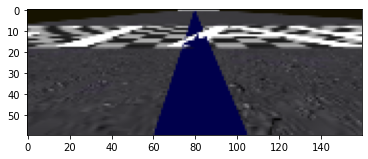

1
(13.0, 0.027000000000000003)
[1.         0.50433554]


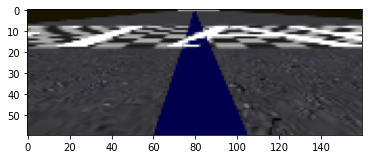

2
(5.0, 0.046)
[0.41176471 0.50738647]


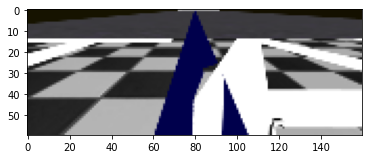

3
(5.0, 0.046)
[0.41176471 0.50738647]


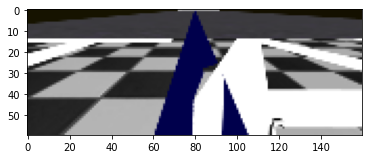

4
(13.0, 0.0211)
[1.         0.50338814]


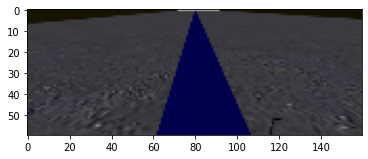

5
(13.0, 0.0216)
[1.         0.50346843]


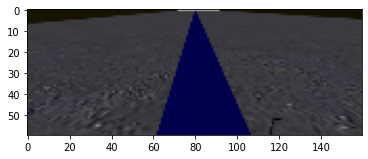

6
(13.0, 0.0157)
[1.         0.50252104]


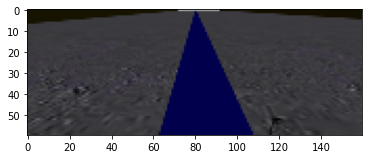

7
(13.0, 0.0044)
[1.         0.50070653]


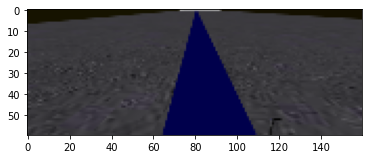

8
(13.0, 0.0054)
[1.         0.50086711]


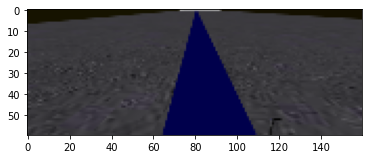

9
(13.0, -0.0005)
[1.         0.49991971]


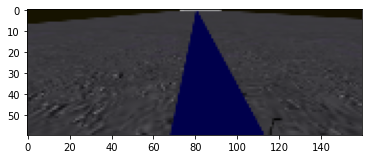

In [ ]:
*def draw_me(img):
    #plt.pause(.001)
    plt.pause(.5)
    plt.imshow(img)

for idx in range(10):
    print(idx)
    print(array_annotations[idx])
    print(normalized_annotations[idx])
    img = array_imgs[idx]
    plt.imshow(img)
    plt.pause(.5)
    #draw_me(img)

'''
PREGUNTAS:
* Están mal normalizados los datos de giro(w)?
* Hay inclinación de los datos hacia la derecha? Siempre suele ir hacia la derecha de la línea?
* Por qué la línea es azul el dataset y en el circuito roja? Afecta eso? Se podría probar quizá en B/W?
* En el many_curves va perfecto pero en el simple_circuit falla siempre en el mismo punto? Por qué?
* Fallos en algunas rosbag
* Fallo al ejecutar play GUI sin stats ativado
* No hay overfitting nunca?
* Debería normalizar los datos de giro entre -1 y 1 porque tiene más sentido.
'''

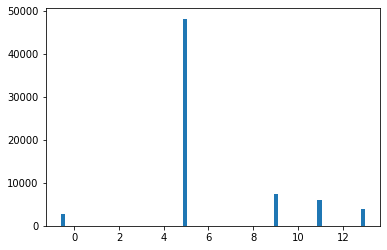

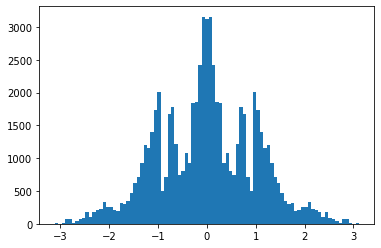

In [80]:
ann_x = []
ann_y = []
for ann in array_annotations:
  ann_x.append(ann[0])
  ann_y.append(ann[1])

n, bins, patches = plt.hist(x=ann_x, bins='auto')
plt.show()
n, bins, patches = plt.hist(x=ann_y, bins='auto')
plt.show()